# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal gradient descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 11th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "hadrien"
ln1 = "piegard"
fn2 = "saphia"
ln2 = "benmansour"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_piegard_hadrien_and_benmansour_saphia.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [33]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b


## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [34]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [35]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j].copy()
        w[j] = w[j] + A[:, j].dot(residuals) / lips_const[j]   
        residuals = residuals - A[:, j].dot(w[j] - old_w_j)
        # update residuals:
        # residuals 
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2 
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(abs(gradient))
        old_w_j = w[j].copy() 
        w[j] -= gradient[j] / lips_const[j]
        gradient += gram[j].dot(w[j] - old_w_j)
#         print(t, gradient)
        # update gradient:
        # gradient
        # END TODO
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

- compute a precise minimum with your favorite solver
- compare the performance of cyclic and greedy CD

- could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features? Explain your answers.

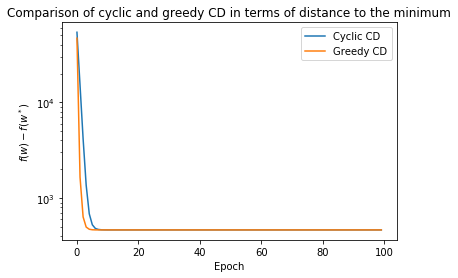

In [36]:
##Compute a precise minimum with your favorite solver
n_iter=10000
w_cy, obj_cy = cyclic_cd(A, b, n_iter)

##Compute the performance of cyclic and greedy CD
w_gr, obj_gr = greedy_cd(A, b, n_iter)

#Compute minimum for OLS loss function
w_min, _, _, _,= np.linalg.lstsq(A, b)
plt.semilogy(obj_cy)
plt.semilogy(obj_gr)
plt.title("Comparison of cyclic and greedy CD in terms of distance to the minimum")
plt.xlabel("Epoch")
plt.ylabel("$f(w) - f(w^*)$")
plt.legend(['Cyclic CD','Greedy CD'])



In [37]:
print( "Distance to the minimizer with cyclic CD", np.linalg.norm(x_min - w_cy))

Distance to the minimizer with cyclic CD 2.39532442514e-14


In [38]:
print( "Distance to the minimizer with greedy CD", np.linalg.norm(x_min - w_gr))

Distance to the minimizer with greedy CD 3.01505808525e-14


We cannot compute greedy CD for unregularized logistic regression.  
We cannot either compute with OLS if we have more features than the number of samples because the matrix A.T.dot(A) would not be invertible.

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
1) Show that:
$$ \lambda \geq \lambda_{max} \implies \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert_1 (w_1)  \times \dots \times \partial \vert \cdot \vert_1 (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert_1 (w_1) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

*answer here*

2) Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.



We take 
$$
g_{j,w}(h)\ =\ f\ (w\ +\ e_jh) 
$$
where f is the function to minimize

We have $$ L_j\ =\ L\ (\nabla g_{j,w})$$

So : $$\nabla^2g_{j,w}\left(h\right)=e_t^jf\left(w+e_ih\right)e_{j\ }=e_t^j\sum_{i=1}^{n}{y_i^2X_iX_i^T}\  ej(\ e^{{y_i(w+e_jh)}^TX_i})/(1\ +\ e^{{y_i(w+e_jh)}^TX_i})² $$

With $$y\in\left[-1,1\right]$$

So : 
$$\nabla^2g_{j,w}\left(h\right)=e_t^j\sum_{i=1}^{n}{X_iX_i^T}\  ej(\ e^{{y_i(w+e_jh)}^TX_i})/(1\ +\ e^{{y_i(w+e_jh)}^TX_i})² $$
And $$\forall\alpha\in R,\ {\ e}^\alpha\ /\ (1+{\ e}^\alpha)² ≤ 1/4$$
So we have
$$\nabla^2g_{j,w}\left(h\right)=e_t^j\sum_{i=1}^{n}{(X_iX_i^T}\ /4)e_{j\ }\le\ e_t^j\sum_{i=1}^{n}{(||X_i^T}e_j||²ej)/4$$
$$||X_j||² / 4$$

You are now ready to code cyclic proximal coordinate descent for sparse Logistic regression:

**Bonus**: show that is possible, when the current iterate is w, to use the better Lipschitz constant 
    $$L_j = \sum_{i=1}^n  \frac{X_{i, j}^2 \mathrm{e}^{(Xw)_i}}{(1 +
\mathrm{e}^{(Xw)_i})^2}$$
    
(why is it better?)

Implement it in the code with a `better_lc` parameter, and compare.

In [49]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 10.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.maximum(0., np.abs(x) - u) * np.sign(x)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.ones(n_features)
    Xw = X.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(X, axis=0)**2 / 4 
    # END TODO
    
    all_objs = []
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = - np.sum(y * X[:,j] * sigmoid(- y * Xw))
            # w[j] = soft_thresh(1, 2)
            w[j] = soft_thresh(w[j] - grad_j / lips_const[j], lamb / lips_const[j])
            
            if old_w_j != w[j]:
                Xw += (w[j] - old_w_j)*X[:,j]
            #END TODO
            all_objs.append(np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1))
    
    return w, all_objs

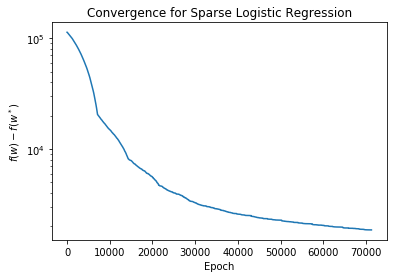

In [106]:
w_cd, obj = cd_logreg(X, y, lamb, 10)
plt.semilogy(obj)
plt.title("Convergence for Sparse Logistic Regression")
plt.xlabel("Epoch")
plt.ylabel("$f(w) - f(w^*)$")
plt.show()

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

You can download the file here: http://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv, and you should place it in the same folder as the current notebook.

In [52]:
from numpy import genfromtxt
y = 2 * (genfromtxt('leukemia_big.csv', delimiter=',', dtype=str)[0] == 'ALL') - 1
X = genfromtxt('leukemia_big.csv', delimiter=',')[1:].T

print(X.shape)
print(y[::10])

(72, 7128)
[ 1  1 -1 -1  1  1  1 -1]


In [55]:
lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.


16.9706461374


Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).

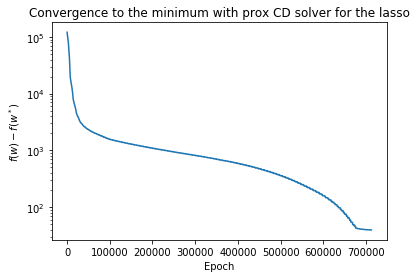

In [107]:
w_cd, obj_cd = cd_logreg(X, y, lambd, 100)
plt.semilogy(obj_cd)
plt.title("Convergence to the minimum with prox CD solver for the lasso")
plt.xlabel("Epoch")
plt.ylabel("$f(w) - f(w^*)$")

In [100]:
def ista(A, b, n_iter=50):
    """Proximal gradient descent algorithm"""
    x = np.ones(len(A[0,:]))
    L = np.linalg.norm(X, 2) ** 2 / 4
    s = 1 / L
    objectives = []
    for k in range(n_iter + 1):

        grad_f = - np.mean(b * A.T * (1. / (1. + np.exp(b * np.dot(A, x)))), axis=1)
        x = np.sign(x - s * grad_f) * np.maximum(np.abs(x - s * grad_f) - s, 0)
        
        f = np.mean(np.log(1. + np.exp(- b * np.dot(A, x)))) 
        g = s * np.linalg.norm(x, 1)
        obj = f + g

        objectives.append(obj)

    return x, objectives

In [101]:
w_gd, obj_gd = ista(X, y, 1000)

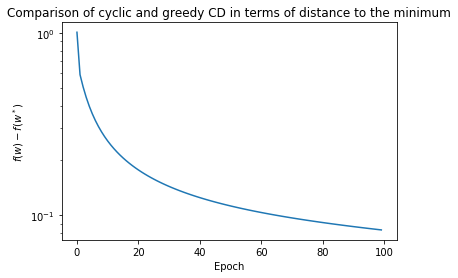

In [108]:
plt.semilogy(obj_gd)
plt.title("Convergence to the minimum with prox gradient solver for the lasso")
plt.xlabel("Epoch")
plt.ylabel("$f(w) - f(w^*)$")

We can notice that both algorithms converge to the minimum. However we cannot really compare their convergence because it is not the same scale and i do not really understand why.